In [27]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.linalg
import pandas as pd

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,5)

# Displacement structure

### Basic idea

FBP can be written as:

$$\mathbf{x}_{\text{FBP}} = A^T C_f \mathbf{b}$$

Here, $C_f$ is a projection-wise convolution with the filter $f$, which means $C_f$ is a block-diagonal Toeplitz matrix.

One of the explicit formulas for the pseudo-inverse is (if $AA^T$ is invertible):

$$A^+ = A^T (AA^T)^{-1}.$$

Since we should have $x \approx A^+ b$, we see that $(AA^T)^{-1}$ might be well approximated by this convolution operator $C_f$. 

Let us first look at a toy parallel-beam problem with two projections.

### Toy problem

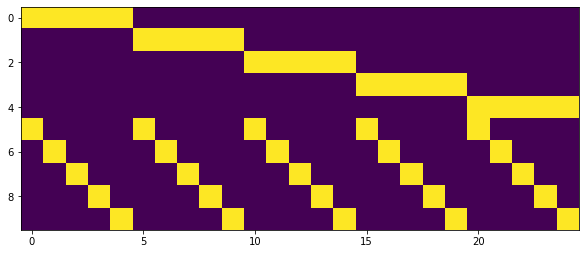

In [2]:
B = np.mat("""\
1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;
0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0;
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0;
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1;
1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0;
0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0;
0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0;
0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0;
0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1""")

plt.imshow(B)

We are interested in approximating $(AA^T)^{-1}$ with a filter, but $AA^T$ is singular.

In [3]:
BBT = B @ B.T
f"{np.linalg.matrix_rank(BBT)} != {BBT.shape[1]}"

'9 != 10'

So we form the pseudo-inverse for comparison

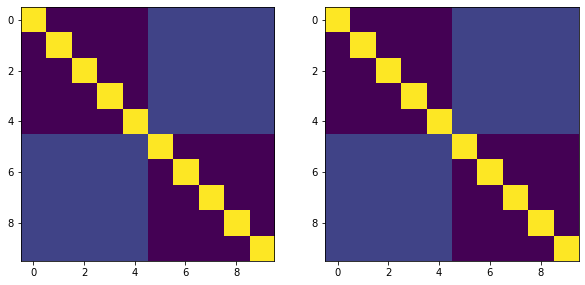

In [4]:
iBBT = np.linalg.pinv(BBT)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(BBT)
ax2.imshow(iBBT)

k = iBBT.shape[0]

### Displacement experiments

We do not expect the (blocks of) $(AA^T)^{-1}$ to be exactly Toeplitz. A generalization of Toeplitz matrices ('near-Toeplitzness') uses the notion of displacement structure. Let us investigate this for our toy problem.

PS: I am not sure if 'well approximated by Toeplitz' implies 'near Toeplitz'. This probably relates to the fast singular value decay of the displaced matrix.

**Definition:**
The displacement of a (symmetric) matrix is defined as: $$\nabla A = A - Z A
Z^T,$$ where $Z$ has ones on the first subdiagonal and zeros elsewhere. The rank
of $\nabla A$ is the displacement rank of $A$.


The second term in the displacement looks like the following:
$$Z A Z^T = \left[ \begin{array}{c | c c c c} 0 & 0 & 0 & \cdots & 0 \\
\hline
0 & & & & \\
0 & & & & \\
\vdots & & & \bar{A} & \\
0 & & & & 
\end{array} \right]$$
Here, $\bar{A}$ is the $(n - 1) \times (n - 1)$ leading principal submatrix of
$A$. In other words, all columns of $A$ are moved to the right and all rows of
$A$ are moved down. For Toeplitz matrices, the value of $a_{i, j}$ is the same
as $a_{i + 1, j + 1}$ for all $i, j < n - 1$. This means that this leading
submatrix is identical to the 'tailing' submatrix of size $n - 1$. Therefore,
the displacement of
a Toeplitz matrix looks like this:

$$ A - Z A Z^T = \left[ \begin{array}{c | c c c} * & * & \cdots & * \\
\hline
* & & & \\
\vdots & & \bar{A} & \\
* & & & 
\end{array} \right] - \left[ \begin{array}{c | c c c} 0 & 0 & \cdots & 0 \\
\hline
0 & & & \\
\vdots & & \bar{A} & \\
0 & & & 
\end{array} \right] =  \left[ \begin{array}{c | c c c} * & * & \cdots & * \\
\hline
* & & & \\
\vdots & & \emptyset & \\
* & & & 
\end{array} \right]$$

where * is some nonzero.

If you have $A - ZRZ^T = NM^T$, where $N$ is tall and $M^T$ is wide, operations like inversion can be done
efficiently because you can write it as the sum of products of lower/upper
triangular Toeplitz matrices. (see: _Displacement ranks of matrices and linear equations, Kailath et al. (1979)_)

For a Toeplitz matrix $T$, $\nabla T$ has rank 2, and therefore such $N, M$ can be found. The inverse of a Toeplitz matrix is no longer Toeplitz, and neither are products of Toeplitz matrices. However, they all still have low disp

rank(T) = 10, rank(nabla T) = 2


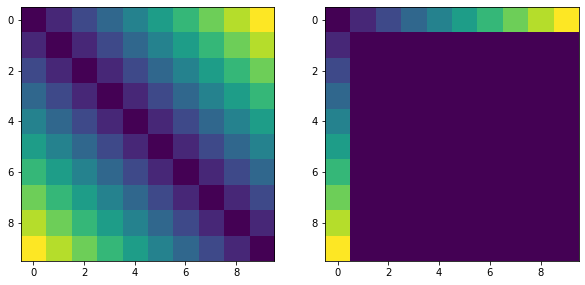

In [5]:
# Try the displacement map
def displace(A):
    k = A.shape[0]
    Z = np.zeros((k, k))
    Z[1:, 0:-1] = np.eye(k - 1)
    return A - Z @ A @ Z.T

# Test on Toeplitz
Ttest = sp.linalg.toeplitz(np.arange(0, k), np.arange(0, k))
nablaT = displace(Ttest)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(Ttest)
ax2.imshow(nablaT)

print(f"rank(T) = {np.linalg.matrix_rank(Ttest)}, rank(nabla T) = {np.linalg.matrix_rank(nablaT)}")

### Displacement map

We revisit our toy problem: ultra-low resolution parallel beam with two projections. First, we displace $(AA^T)^{-1}$.

rank(nabla iBBT) = 4


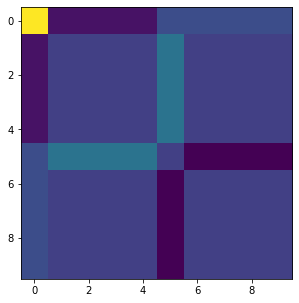

In [7]:
# Form displaced B
X = displace(iBBT)
plt.imshow(X)
print(f"rank(nabla iBBT) = {np.linalg.matrix_rank(X)}")

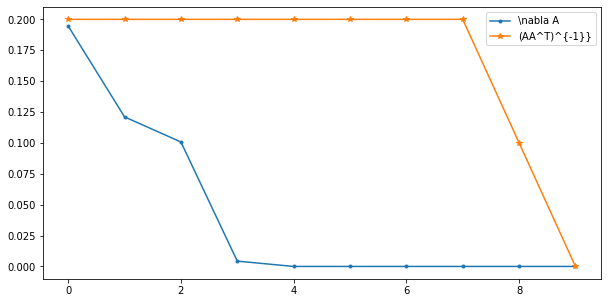

In [13]:
# Plot singular value decay
u, s, vh = np.linalg.svd(X)
u2, s2, vh2 = np.linalg.svd(iBBT)

plt.plot(s, marker='.', label='\\nabla A')
plt.plot(s2, marker='*', label='(AA^T)^{-1}}')
plt.legend()
plt.show()

Note that $\nabla (AA^T)^{-1}$ has the faster singular value decay. However, we are ignoring the fact that we actually want to use the diagonal blocks. We'll focus on exploting the block structure later, first let us explore how we can use the rapid singular value decay.

Let:

$W(A) = A - Z_0 A Z_0^T = GH^T$

where $G, H$ are tall and skinny (width $d$). Then the _displacement representation_ is

$A = A(G, H) = \sum_{i = 1}^d L(g_i) L^T(h_i)$

where, $g_i$ and $h_i$ are the columns of $g$ and $h$ respectively, and $L(v)$
is the trianglar Toeplitz matrix defined by its first column $v$. With this
representation, we see that multiplying with $A$ can be done efficiently, because multpliying with the triangular Toeplitz matrices can be done using FFTs.

In [20]:
# Form displacement representation

# (1) Form G, H
d = 4
G = u[:, :d]
S = np.diag(s[:d])
HT = S @ vh[:d, :]
H = HT.T
k = G.shape[0]

# (2) Form triangular Toeplitz matrices
Ls = []
Us = []
for i in range(0, d):
    row = np.zeros(k)
    row[0] = G[0, i]
    lower = sp.linalg.toeplitz(G[:, i], row)
    Ls.append(lower)
    col = np.zeros(k)
    col[0] = H[0, i]
    upper = sp.linalg.toeplitz(col, H[:, i])
    Us.append(upper)
    
# (3) Test result
Y = np.zeros(iBBT.shape)
for i in range(0, d):
    Y += Ls[i] @ Us[i]
print(f"norm of difference: {np.linalg.norm(Y - iBBT)}")

norm of difference: 5.492612292813377e-16


### Reconstruction tests

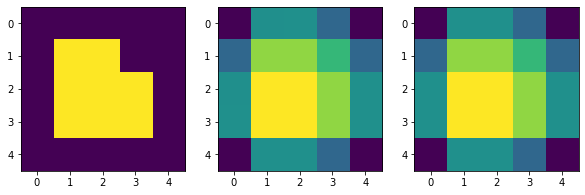

In [23]:
# run 'reconstruction', i.e. use nabla iBBT
# still have to untangle the Z's...
# hiow do we do this
_, (ax1, ax2, ax3) = plt.subplots(1, 3)

phantom = np.zeros((5, 5))
phantom[1:4, 1:4] = 1
phantom[1, 3] = 0
b = B @ phantom.reshape((25, 1))

ax1.imshow(phantom.reshape((5, 5)))

xrecon = B.T @ Y @ b

ax2.imshow(xrecon.reshape((5, 5)))

# Compare with just backprojecting
ax3.imshow((B.T @ b).reshape((5, 5)))

In [35]:
bp_recon = [np.linalg.norm(B.T @ b - phantom.flatten()), np.linalg.norm(B @ B.T @ b - b)]
dbp_recon = [np.linalg.norm(B.T @ Y @ b - phantom.flatten()), np.linalg.norm(B @ B.T @ Y @ b - b)]
ibp_recon = [np.linalg.norm(B.T @ iBBT @ b - phantom.flatten()), np.linalg.norm(B @ B.T @ iBBT @ b - b)]
pd.DataFrame([bp_recon, dbp_recon, ibp_recon], index=["A^T b", "A^T \nabla (AA^T)^{-1} b", "A^T (AA^T)^{-1} b"], columns=["error", "residual"])

,error,residual
A^T b,87.292611,4.866210e+01
A^T \nabla (AA^T)^{-1} b,15.099669,5.247199e-15
A^T (AA^T)^{-1} b,15.099669,2.311225e-15


### Application to single projection low-res parallel beam

We construct a low-resolution parallel-beam geometry with a limited number of projections.

In [74]:
import astra

n_small = 32
p_small = n_small

In [75]:
# get explicit matrix from ASTRA
def construct_pbeam_matrix(n, p):
    vol_geom = astra.create_vol_geom(n, n)
    proj_geom = astra.create_proj_geom('parallel', 1.0, n, np.linspace(0,np.pi,p,False))
    proj_id = astra.create_projector('line', proj_geom, vol_geom)
    matrix_id = astra.projector.matrix(proj_id)
    W = astra.matrix.get(matrix_id)
    return W

In [76]:
W = construct_pbeam_matrix(n_small, p_small)

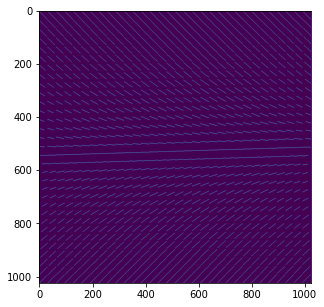

In [77]:
plt.imshow(W.toarray())

#### Reconstruction test

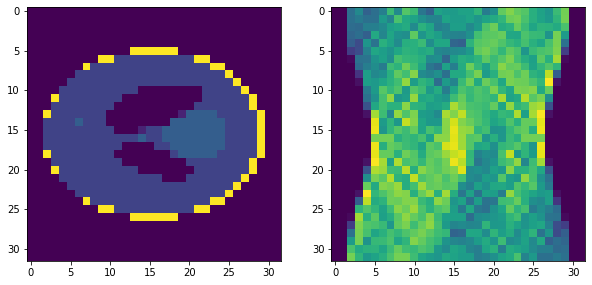

In [79]:
# Prepare Shepp-Logan phantom and sinogram
import odl
reco_space = odl.uniform_discr(
    min_pt=[0, 0], max_pt=[1, 1], shape=[n_small, n_small], dtype='float32')
phantom_image = odl.phantom.shepp_logan(reco_space, modified=True)
x_phantom = phantom_image.data.reshape((n_small * n_small,))
b_phantom =  W @ x_phantom

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(phantom_image)
ax2.imshow(b_phantom.reshape((p_small, n_small)))

In [80]:
# We prepare some matrix
WWT = (W @ W.T).toarray()
pWWT = np.linalg.pinv(WWT)

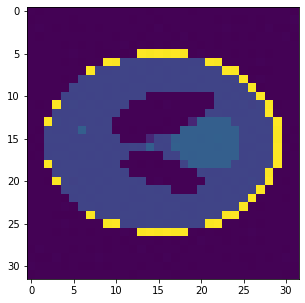

In [82]:
# Sanity check: reconstruction
x = W.T @ pWWT @ b_phantom
plt.imshow(x.reshape((n_small, n_small)))

First, let us check again what happens if we ignore the blocks and simply check the displacement of $(WW^T)^+$.

#### Displacement

In [91]:
def compare_svd(A, B):
    u, s, vh = np.linalg.svd(A)
    u2, s2, vh2 = np.linalg.svd(B)

    plt.semilogy(s, marker='.', label='A')
    plt.semilogy(s2, marker='*', label='B')
    plt.legend()
    plt.show()

rank(nabla (WW^T)^+) = 629


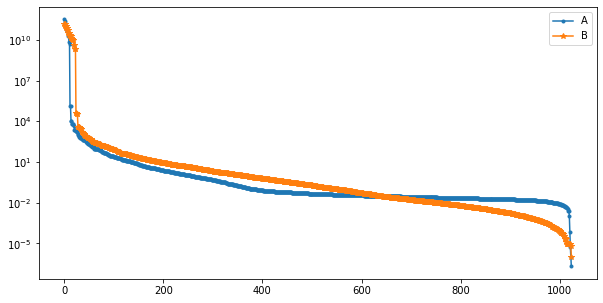

In [92]:
dW = displace(pWWT)
print(f"rank(nabla (WW^T)^+) = {np.linalg.matrix_rank(dW)}")
compare_svd(pWWT, dW)

Definitely not significant, so we'll (as expected) have to move to blocks for this. Going to a 'single projection' matrix $P$ does not work, which might be a bad sign.

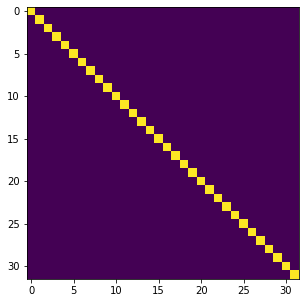

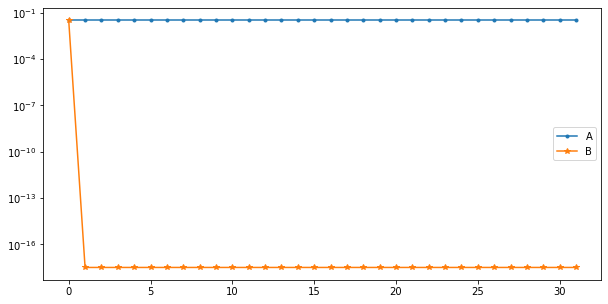

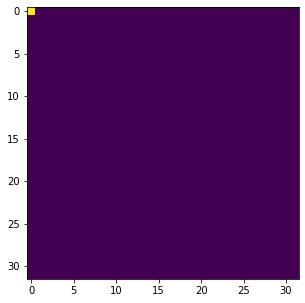

In [113]:
P = construct_pbeam_matrix(n_small, 1)
PPT = (P @ P.T).toarray()
pPPT = np.linalg.pinv(PPT)
plt.imshow(PPT)
plt.show()
compare_svd(pPPT, displace(pPPT))
plt.imshow(displace(pPPT))
plt.show()

Note that here, although it definitely does drop immediately, which is what we would hope (as there is only one 'block' in $(PP^T)^{-1}$. , we see that the displaced matrix is just a single element in the top left. This does make sense though -- the PP^T are the inner products of the rows of the projection matrix, which are mutually orthogonal within a single projection block. So we get a constant diagonal matrix for $PP^T$ and its inverse. Then the displaced $(PP^T)^{-1}$ consisting of a single element matrix, giving us no hope for the tall-skinny decomposition.

We can try also with the Sylvester map and $Z_1, Z_{-1}$ which might be more appropriate.

### Exploiting symmetry

Reconstructing with a single projection is not very useful, so we'll have to be smarter about it. I could see two approaches:

1. exploit symmetry, and try to solve it for a single block and copy the result to multiple blocks
2. actually do take into account the number of projections, and use Schur complements to compute the block -- followed either by copying to each block on the basis of symmetry, or repeating the process for each block

We have seen that option 1 does not work, so we'll attempt option 2.

By comparing Schur blocks, we see:

$$WW^T / W_{2:} W_{2:}^T \equiv W_1 W_1^T - W_1 W_{2:}^T (W_{2:} W_{2:}^T)^+ W_{2:} W_1^T.$$
$$(WW^T / W_{2:} W_{2:}^T)^+ \approx C_f^{(1d)}$$

In [172]:
def pinv(X):
    return np.linalg.pinv(X)

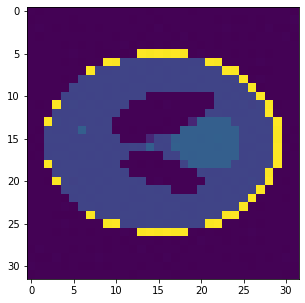

In [183]:
# form the block matrix WW^T
W1 = W[:n_small, :]
W2 = W[n_small:, :]
pWWT2 = np.linalg.pinv((W2 @ W2.T).todense())
A = (W1 @ W1.T).todense()
B = (W1 @ W2.T).todense()
C = (W2 @ W1.T).todense()
D = (W2 @ W2.T).todense()
# sanity check #1
G = np.block([[A, B], [C, D]])
x = W.T @ pinv(G) @ b_phantom
plt.imshow(x.reshape(n_small, n_small))

In [184]:
# upper left block
pD = pinv(D)
iA = pinv(A - B @ pD @ C)

In [187]:
# other blocks
iB = -iA @ B @ pD
iC = -pD @ C @ iA
iD = pinv(D - C @ pinv(A) @ B)

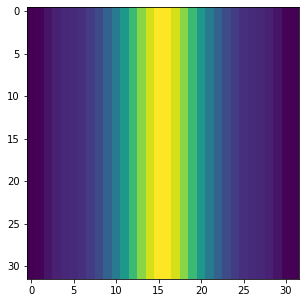

In [205]:
# Use the blocks
pS = np.block([[iA, iB], [iC, iD]])

x = W.T @ pS @ b_phantom
plt.imshow(x.reshape(n_small, n_small))

In [198]:
print(np.linalg.norm(iD) / np.linalg.norm(iA))

87.5234999786


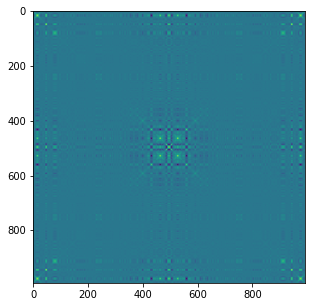

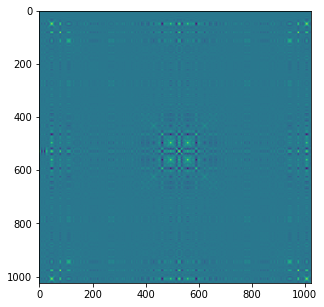

In [209]:
plt.imshow(iD)
plt.show()
plt.imshow(pS)
plt.show()

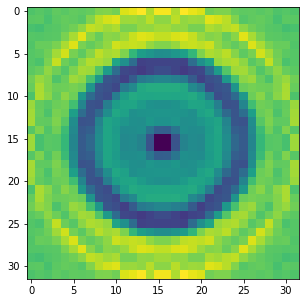

In [147]:
# try a reconstrucftion with iA?
block_iA = np.kron(np.identity(n_small), iA)
x = W.T @ block_iA @ b_phantom
plt.imshow(x.reshape(n_small, n_small))

In [ ]:
pSW1 = np.linalg.pinv(SW1)

In [ ]:
dSW1 = displace(SW1)
u, s, vh = np.linalg.svd(dSW1)
plt.semilogy(s, marker='.', label='$\nabla S(W)$')
plt.show()

In [88]:
# pd.DataFrame([bp_recon, dbp_recon, ibp_recon], index=["A^T b", "A^T \nabla (AA^T)^{-1} b", "A^T (AA^T)^{-1} b"], columns=["error", "residual"])

### The real stuff

Actually blocks and stuff.

Try same thing wiht $A^T A$ and 2D convoluion, or blocks on $AA^T$.

In [ ]:
WWT = (W @ W.T).toarray()
pWWT = np.linalg.pinv(WWT)

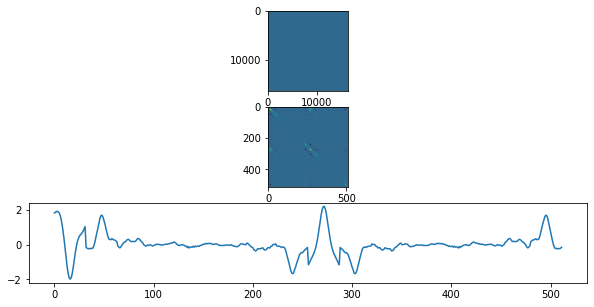

In [61]:
# Recon with the dense WWT+
block_pWWT = np.kron(np.identity(n_small), pWWT)

_, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.imshow(block_pWWT)
ax2.imshow(pWWT)
ax3.plot(pWWT[0, :])
plt.show()

In [ ]:
recon_pseudo = (Wf.T @ block_pWWT @ b_phantom)
plt.imshow(recon_pseudo.reshape((n_small, n_small)))

In [ ]:
recon_bp = (Wf.T @ (b_phantom))
plt.imshow(recon_bp.reshape((n_small, n_small)))

In [ ]:
print(f"recon errors: {np.linalg.norm(recon_pseudo - x_phantom) / np.linalg.norm(x_phantom), np.linalg.norm(recon_bp - x_phantom) / np.linalg.norm(x_phantom)}")
print(f"recon residuals: {np.linalg.norm(Wf @ recon_pseudo - b_phantom) / np.linalg.norm(b_phantom), np.linalg.norm(Wf @ recon_bp - b_phantom) / np.linalg.norm(b_phantom)}")

In [ ]:
# Astra pinv

recon_pinv = (Wf.T @ np.linalg.pinv((Wf @ Wf.T).todense()) @ (b_phantom))
plt.imshow(recon_pinv.reshape((n_small,n_small)))

In [ ]:
# get explicit matrix from ASTRA
n = 8
p = 8
vol_geom = astra.create_vol_geom(n, n)
proj_geom = astra.create_proj_geom('parallel', 1.0, n, np.linspace(0,np.pi,p,False))
proj_id = astra.create_projector('line', proj_geom, vol_geom)
matrix_id = astra.projector.matrix(proj_id)
W = astra.matrix.get(matrix_id)

WWT = (W @ W.T).toarray()
WTW = (W.T @ W).toarray()

plt.imshow(WWT)

In [ ]:
plt.imshow(WTW)

In [ ]:
(W @ W.T)

In [ ]:
(W.T @ W)

In [ ]:
64 * 64

# Appendix (experiments with poor results)

### Ram-Lak experiments (WIP)

**TODO:** Need to double check all this, as it doesnt check out atm

Now we form the standard convolution with the Ram-Lak filter. (Normalization?)

A (discrete) convolution as a linear operation has a lot of structure. A
Toeplitz matrix has constant diagonals. Let $m = 2k + 1$. A 1D convolution of a
vector $\vec{y} \in \mathbb{R}^{m}$ by $\vec{x} \in \mathbb{R}^{2k + 1}$
(indexed $x_{-k}, \ldots, x_k$), is a Toeplitz matrix of size $m \times m$.

$$\vec{y} * \vec{x} = T \vec{y}, \qquad T =
\begin{bmatrix} x_0 & x_1 & \ddots & x_k & 0 & \ddots \\
x_{-1} & x_0 & x_1 & \ddots & x_k & \ddots \\
x_{-2} & x_{-1} & x_0 & x_1 & \ddots & \ddots \\
\ddots & \ddots & \ddots & \ddots & \ddots & \ddots \\
\end{bmatrix}.$$

- The 1D filtering of data in tomography happens row-by-row on the detector. If
  we order the data by projection, and in a row-major order, then this
  transformation corresponds to a block diagonal matrix, where each block is
  Toeplitz.
  $$A^+ = A^T (AA^T)^{-1},$$ which means we might be able to use this block
  version for approximations of $(AA^T)^{-1}$.

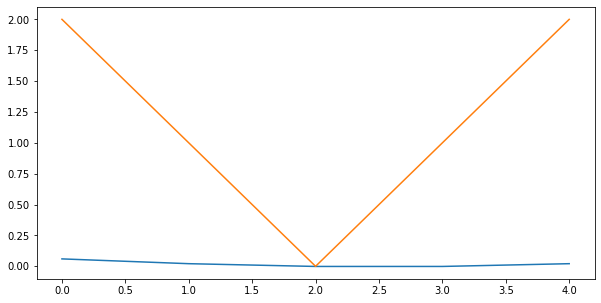

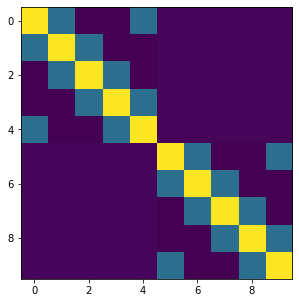

In [114]:
# Play around with Ram-Lak
n = 5
down = np.array(np.arange(n // 2, 0, -1))
up = np.array(np.arange(0, n // 2 + 1, 1))
ramlak = np.concatenate((down, up))

framlak = np.real(np.fft.ifft(ramlak)) / (n * (n - 1))
plt.plot(framlak)
plt.plot(ramlak)
plt.show()

Cb = sp.linalg.toeplitz(framlak, framlak)
C = sp.linalg.block_diag(Cb, Cb)
plt.imshow(C)

In [ ]:
# Compare with iBBT
print(f"shapes: {iBBT.shape} == {C.shape}")
niBBT = iBBT / np.linalg.norm(iBBT)
nC = C / np.linalg.norm(C)
print(f"norm of difference: {np.linalg.norm(nC - niBBT)}")

# Compare residuals
b = np.ones((B.shape[0], 1))

xg = sp.linalg.toeplitz(np.arange(0, 5, 1), np.arange(0, 5, 1))
xg = xg.reshape((n * n, 1))
b = B @ xg

x_C = B.T @ C @ b
x_p = B.T @ iBBT @ b

print(np.linalg.norm(b - B @ x_C), np.linalg.norm(b - B @ x_p))

### Sylvester map

(This is from 12.1 in Golub and van Loan). Apparently, you can also look at displacement rank through the $\{F, G\}$ Sylvester map:
$$X \mapsto F X - X G.$$
The rank of the displaced $X$ is the displacement rank. If $Z_\phi$ is the matrix with ones on the subdiagonal, and $\phi$ in the top right corner, then a matrix with low $\{Z_1, Z_{-1} \}$ displacement rank is "Toeplitz-like". Let's explore this too.

In [ ]:
# Maybe do Id, and then pad with zero row/column, and put 1 in upper right corner?
# What is Z, and what is Y (sub, super?)
Z = np.zeros((k, k))
Z[1:, 0:-1] = np.eye(k - 1)
Y = Z.copy()
Z[0, k - 1] = 1
# I do not remember where this -1 comes from
Y[0, k - 1] = -1

def sylvester(Z, Y, A):
    return Z @ A - A @ Y

# Test on Toeplitz
Ttest = sp.linalg.toeplitz(np.arange(0, k), np.arange(0, k))
nablaT = sylvester(Z, Y, Ttest)
_, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(Z)
ax2.imshow(Ttest)
ax3.imshow(nablaT)

print(f"rank(T) = {np.linalg.matrix_rank(Ttest)}, rank(nabla T) = {np.linalg.matrix_rank(nablaT)}")

In [ ]:
# Form displaced B
X = sylvester(Z, Y, iBBT)
plt.imshow(X)
print(f"rank(nabla iBBT) = {np.linalg.matrix_rank(X)}")

In [ ]:
# We now know that nabla iBBT has low rank, lets find a factorization that witnesses this.
u, s, vh = np.linalg.svd(X)
R = u[:, :3]
S = np.diag(s[:3])
ST = S @ vh[:3, :]
print(f"norm of difference: {np.linalg.norm((R @ ST) - X)}")

**TODO**:
- Maybe this is an (even) more appropriate representation
- Do we also have a sum-of-Toeplitz-products representation for this?